# Create a STAC-aware GeoZarr RGB tile of a Sentinel-2 scene over Vienna.

This example demonstrates a best-practice workflow for creating a STAC-aware,
interoperable GeoZarr store from Sentinel-2 Cloud-Optimized GeoTIFFs (COGs).

The key steps are:

1.  Query Earth-Search for a recent, low-cloud Sentinel-2 L2A scene.
2.  Stream and stack the source RGB bands into a single, lazy xarray.DataArray.
3.  Prepare a GeoZarr-compliant xarray.Dataset in memory, which includes
    embedding STAC metadata and refining the CRS attributes.
4.  Write the final, consolidated GeoZarr store.
5.  Verify the result by reopening the store and inspecting the STAC metadata.
6.  Display a coarsened preview of the RGB image.

In [1]:
"""Create a STAC-aware GeoZarr RGB tile of a Sentinel-2 scene over Vienna."""

import warnings
from datetime import date
from pathlib import Path

import jsonschema
import matplotlib.pyplot as plt
import pystac_client
import rioxarray as rxr
import xarray as xr

## Query Earth-Search for a recent, low-cloud Sentinel-2 L2A scene.

In [2]:
print("Step 1: Querying for a Sentinel-2 scene over Vienna...")
API = "https://earth-search.aws.element84.com/v1"
coll = "sentinel-2-l2a"
bbox = [16.20, 48.10, 16.45, 48.30]  # Vienna
today = date.today()
last_year = today.replace(year=today.year - 1)
daterange = f"{last_year:%Y-%m-%d}/{today:%Y-%m-%d}"

item = next(
    pystac_client.Client.open(API)
    .search(
        collections=[coll],
        bbox=bbox,
        datetime=daterange,
        query={"eo:cloud_cover": {"lt": 5}},
        limit=1,
    )
    .items(),
    None,
)
if not item:
    raise RuntimeError("No Sentinel-2 scene found for the specified criteria.")
print(f"Found scene: {item.id} (Cloud cover: {item.properties['eo:cloud_cover']:.2f}%)")

Step 1: Querying for a Sentinel-2 scene over Vienna...
Found scene: S2A_33UWP_20250620_0_L2A (Cloud cover: 4.52%)


## Stream and stack the source RGB bands into a lazy DataArray.

In [3]:
print("\nStep 2: Streaming and stacking source COG bands...")
bands = ["red", "green", "blue"]
rgb = xr.concat(
    [
        rxr.open_rasterio(
            item.assets[b].href, chunks={"band": 1, "x": 2048, "y": 2048}, masked=True
        ).assign_coords(band=[b])
        for b in bands
    ],
    dim="band",
)
rgb.name = "radiance"
# Assign the Coordinate Reference System from the STAC item's properties.
rgb = rgb.rio.write_crs(item.properties["proj:code"])


Step 2: Streaming and stacking source COG bands...


## Prepare a complete, GeoZarr-compliant xarray.Dataset in memory.

In [4]:
print("\nStep 3: Preparing the final xarray.Dataset with all metadata...")
# Convert the stacked RGB DataArray into a Dataset and name the data variable
radiance_ds = rgb.to_dataset(name="radiance")

# Grab the original GeoTransform from the DataArray
transform = rgb.rio.transform()

# Ensure x/y are recognized as spatial dims, then write transform + CRS at the dataset level
radiance_ds = (
    radiance_ds.rio.set_spatial_dims(x_dim="x", y_dim="y")
    .rio.write_transform(transform)
    .rio.write_crs(item.properties["proj:code"])
)

# Remove the "spatial_ref" attribute because it is redundant with "crs_wkt" and not included in CF conventions.
_ = radiance_ds["spatial_ref"].attrs.pop("spatial_ref", None)


Step 3: Preparing the final xarray.Dataset with all metadata...


## Build the STAC Item metadata dictionary

In [5]:
gsd = min(item.assets[b].to_dict().get("gsd", 10) for b in bands)
store_path = Path(f"../output/{coll}_{'_'.join(bands)}_{item.id}.zarr")
stac_metadata = {
    "type": "Item",
    "stac_version": "1.0.0",
    "id": item.id,
    "bbox": item.bbox,
    "geometry": item.geometry,
    "properties": {
        "datetime": item.properties["datetime"],
        "proj:code": item.properties["proj:code"],
        "platform": item.properties["platform"],
        "instruments": item.properties["instruments"],
        "eo:cloud_cover": item.properties["eo:cloud_cover"],
        "gsd": gsd,
    },
    "assets": {
        "data": {
            "href": store_path.name,
            "type": "application/x-zarr",
            "roles": ["data"],
        }
    },
    "license": item.properties.get("license", "proprietary"),
}
# Basic STAC schema check
jsonschema.validate(
    instance=stac_metadata,
    schema={"type": "object", "required": ["type", "id", "stac_version", "assets"]},
)
# Embed it in the dataset attrs
radiance_ds.attrs["stac"] = stac_metadata

## Write the final, consolidated GeoZarr store to disk.

In [6]:
print(f"\nStep 4: Writing the final GeoZarr store to '{store_path}'...")

# Ignore warnings about codecs, datetimes, and consolidated metadata not currently being part of the
# Zarr format 3 specification, since it is not relevant for this example.
warnings.filterwarnings("ignore", message=".*Zarr format 3 specification.*")

# Mode 'w' will remove everything in the store_path before writing new data.
store = radiance_ds.chunk({"y": 512, "x": 512}).to_zarr(
    store_path, mode="w", consolidated=True
)


Step 4: Writing the final GeoZarr store to '../output/sentinel-2-l2a_red_green_blue_S2A_33UWP_20250620_0_L2A.zarr'...


## Verify the result by reopening the store and checking for STAC metadata.

In [7]:
print("\nStep 5: Verifying the created GeoZarr store...")
with xr.open_zarr(store_path, consolidated=True) as verified_ds:
    if "stac" not in verified_ds.attrs:
        raise RuntimeError("FAIL: STAC metadata was not found.")
    print("✅ SUCCESS: Embedded STAC metadata was found.")


Step 5: Verifying the created GeoZarr store...
✅ SUCCESS: Embedded STAC metadata was found.


## Display a coarsened preview of the RGB image.


Step 6: Generating and displaying a coarsened preview...


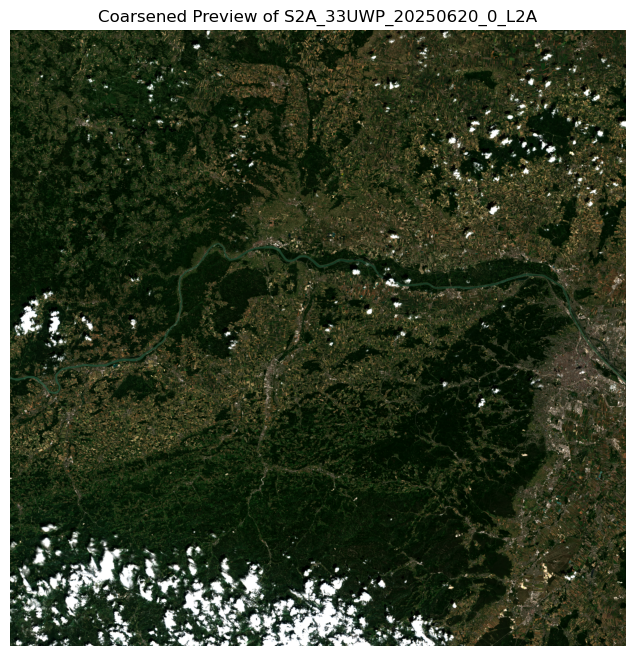

In [8]:
print("\nStep 6: Generating and displaying a coarsened preview...")
with xr.open_zarr(store_path, consolidated=True) as ds_to_plot:
    preview = ds_to_plot.radiance.coarsen(y=8, x=8, boundary="trim").mean()

    # Apply a simple contrast stretch for better visualization.
    p2, p98 = preview.quantile(0.02), preview.quantile(0.98)

    preview_stretched = preview.clip(min=p2, max=p98)
    preview_stretched = (preview_stretched - p2) / (p98 - p2)

    rgb_preview = preview_stretched.transpose("y", "x", "band").values

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(rgb_preview)
    ax.set_title(f"Coarsened Preview of {item.id}")
    ax.set_axis_off()
    plt.show()